In [1]:
from torchvision.datasets import CelebA
from dataset_by_person import CelebAByPerson

import numpy as np
import seaborn as sns

In [2]:
dataset = CelebA(root='.')

In [3]:
from collections import Counter
ids = [_id for _id, _ in Counter(dataset.identity.flatten().tolist()).most_common(50)]

In [4]:
dataset = CelebAByPerson(ids=ids, root='.')

In [5]:
len(dataset)

1524

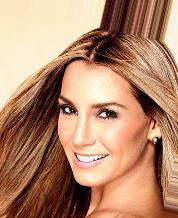

In [6]:
image, _ = dataset[0]
image

/Users/work/miniconda3/envs/face_clustering/lib/python3.9/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


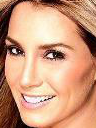

In [7]:
from facenet_pytorch import MTCNN, InceptionResnetV1
from PIL import Image

mtcnn = MTCNN(margin=20, select_largest=False)
resnet = InceptionResnetV1(pretrained='vggface2').eval()

bbox, _ = mtcnn.detect(image)
image.crop(bbox[0].tolist())

In [8]:
import torch
from tqdm import tqdm

batch_size = 32
total = len(dataset)
all_faces = []
all_embeddings = []

for i in tqdm(range(0, total, batch_size)):
    lb = i
    ub = min(i + batch_size, total)
    batch = [dataset[j][0] for j in range(lb, ub)]
    
    faces = mtcnn(batch)
    
    embeddings = [
        None if face is None else resnet(face.unsqueeze(0))
        for face in faces
    ]
    
    all_faces.extend(faces)
    all_embeddings.extend(embeddings)

  2%|█▋                                                                            | 1/48 [00:03<02:32,  3.25s/it]/Users/work/miniconda3/envs/face_clustering/lib/python3.9/site-packages/facenet_pytorch/models/utils/detect_face.py:183: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch_boxes, batch_points = np.array(batch_boxes), np.array(batch_points)
/Users/work/miniconda3/envs/face_clustering/lib/python3.9/site-packages/facenet_pytorch/models/mtcnn.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  boxes = np.array(boxes)
/Users/work/miniconda3

In [9]:
ids = [int(x[1][1]) for x in dataset]

In [10]:
embedding_id_pairs = [
    (_id, embedding)
    for _id, embedding in zip(ids, all_embeddings)
    if embedding is not None
]

In [12]:
embeddings_arr = np.concatenate([e.detach().numpy() for _, e in embedding_id_pairs])
embeddings_ids = np.array([_id for _id, _ in embedding_id_pairs])
embeddings_arr.shape, embeddings_ids.shape

((1522, 512), (1522,))

In [13]:
np.save('embeddings', embeddings_arr)
np.save('ids', embeddings_ids)

In [6]:
import numpy as np
import seaborn as sns

embeddings_arr = np.load('embeddings.npy')
embeddings_ids = np.load('ids.npy')
embeddings_arr.shape

(1522, 512)

In [21]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

vbgmm = BayesianGaussianMixture(n_components=100, random_state=42, verbose=2)
clusters = vbgmm.fit_predict(embeddings_arr)

Initialization 0
Initialization converged: True	 time lapse 56.91564s	 ll 2019861458.51278


In [3]:
person_id_mappings = {_id: i for i, _id in enumerate(sorted(np.unique(embeddings_ids)))}
ids_mapped = [person_id_mappings[_id] for _id in embeddings_ids]

In [22]:
from collections import Counter

Counter(clusters).most_common(50)

[(287, 11),
 (302, 9),
 (56, 8),
 (411, 8),
 (71, 8),
 (455, 7),
 (111, 7),
 (197, 7),
 (398, 7),
 (286, 6),
 (19, 6),
 (525, 6),
 (153, 6),
 (218, 6),
 (133, 6),
 (334, 6),
 (730, 6),
 (137, 6),
 (140, 6),
 (349, 6),
 (482, 6),
 (550, 6),
 (67, 6),
 (773, 6),
 (103, 5),
 (127, 5),
 (544, 5),
 (34, 5),
 (564, 5),
 (724, 5),
 (671, 5),
 (21, 5),
 (289, 4),
 (417, 4),
 (184, 4),
 (142, 4),
 (240, 4),
 (108, 4),
 (54, 4),
 (986, 4),
 (59, 4),
 (978, 4),
 (235, 4),
 (410, 4),
 (374, 4),
 (10, 4),
 (532, 4),
 (89, 4),
 (148, 4),
 (87, 4)]

In [4]:
len(clusters), len(ids_mapped)

(1522, 1522)

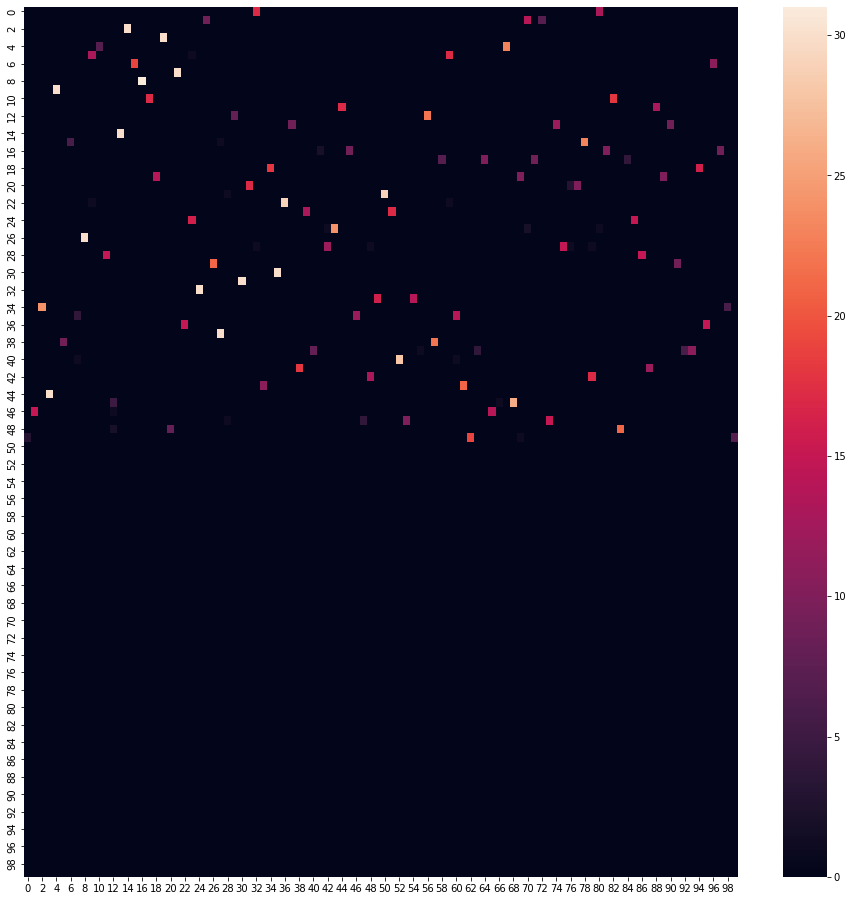

In [11]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(ids_mapped, clusters)

plt.figure(figsize=(16, 16))
ax = sns.heatmap(cm)  # , annot=True, fmt="d", cmap="Blues")